<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_com_amostras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [ ]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


  Using cached torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (804.1 MB)
  Using cached torchvision-0.9.1-cp37-cp37m-manylinux1_x86_64.whl (17.4 MB)
  Using cached torchaudio-0.8.0-cp37-cp37m-manylinux1_x86_64.whl (1.9 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to

In [ ]:
!nvidia-smi

Thu Aug 12 23:07:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |   7324MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [ ]:
#!rm *.csv
#!!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/valid.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/miscelanea.csv
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
path = '/gdrive/My Drive/Colab Notebooks'
KEY='4/1AX4XfWjFfXOpQF_Lhhwz8Sp5DTauJAEXNDQjx66Khyme5ASsCvDLtcqsBX0'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [ ]:
#%cd amostra_news_integrada
#!unzip drive-download-20210731T211249Z-001.zip
#!ls -lh

#!mkdir bertimbau_all_categ


In [ ]:
#!mkdir ./bertimbau_all_categ/amostra_4


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'


In [ ]:
!ls 

 amostra_news_integrada		       'Cópia de BERTimbau_Testes (3).ipynb'
 artigosWikibr.ipynb		       'Cópia de BERTimbau_Testes.ipynb'
 BERTimbau_com_amostras.ipynb	        news_integradas.csv
 bertimbau_resp			        Untitled
'Cópia de BERTimbau_Testes (1).ipynb'   Untitled1.ipynb
'Cópia de BERTimbau_Testes (2).ipynb'


In [ ]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hyper-parameter
MAX_SEQ_LEN = 128 #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
bs = 16
lr = 1e-5



# Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('label', label_field)]





In [ ]:
def tokenizaAmostra(source_folder, fields=fields):
  # TabularDataset
  train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                            test='test.csv', format='CSV', fields=fields, skip_header=True)
  # Iterators

  train_iter = BucketIterator(train, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=bs, device=device, train=False, shuffle=False, sort=False)
  return [train_iter, valid_iter, test_iter]



In [ ]:
#print(vars(train[0]))
#print(vars(valid[0]))
#print(vars(test[0]))

## Modelo

In [ ]:
'''É preciso informar o número de labels '''
class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea



## Treinamento

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def create_directory(path, directory):
  try:
    os.makedirs(path + '/' + directory)
  except FileExistsError:
    # directory already exists
    pass

In [ ]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
    print('1 - inicializando variávies')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print('1 - inicializando treinamento')
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            #print('label size:', labels.size())
            #print('label:', labels)
            labels = labels.to(device)
            text = text.type(torch.LongTensor) 
            #print('text:', text.size())
            text = text.to(device)
            #print('treina...')
            output = model(text, labels)
            #print('fim treino...')
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
%%time
qtd_categories=[32]
#token_train, token_valid, token_test = [],[],[]
id_planilha = [7]
dataset = [1]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
  create_directory(destination_folder,str(id_))
  file_path = destination_folder + "/"+str(id_)
  print(file_path)
  model = BERT(qtd_categories=qtd_categories[idx]).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  inicio = datetime.now()
  print('Treinando amostra:', amostra, 'inicio:', inicio)
  tokens = tokenizaAmostra(source_folder+str(amostra))
  #token_train.append(tokens[0])
  #token_valid.append(tokens[1])
  #token_test.append(tokens[2])
  train(model=model, 
      optimizer=optimizer,
      num_epochs=10,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2,
      file_path=file_path)
  print('Duracao:', datetime.now()-inicio)

./bertimbau_resp/7


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 1 inicio: 2021-08-12 23:36:28.066038
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/10], Step [80/1600], Train Loss: 3.3831, Valid Loss: 3.3216
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [1/10], Step [160/1600], Train Loss: 3.2339, Valid Loss: 3.0489
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [2/10], Step [240/1600], Train Loss: 2.8240, Valid Loss: 2.7383
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [2/10], Step [320/1600], Train Loss: 2.6128, Valid Loss: 2.4791
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [3/10], Step [400/1600], Train Loss: 2.1848, Valid Loss: 2.2689
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [3/10], Step [480/1600], Train Loss: 2.0983, Valid 

In [ ]:
#!ls ./amostra_news_integrada/

#!rm  ./bertimbau_all_categ/amostra_4/*.*

!du -sh

3.4G	.


## Valor da função LOSS na descida do gradiente 
por id de experimento registrado na planilha de controle

Model loaded from <== ./bertimbau_resp/2/metrics.pt


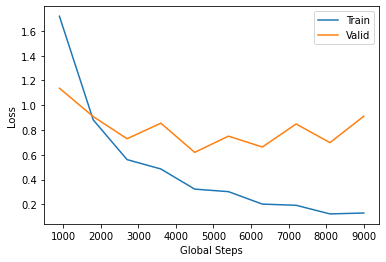

Model loaded from <== ./bertimbau_resp/4/metrics.pt


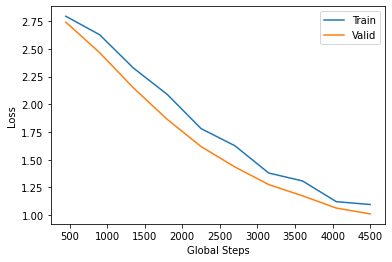

Model loaded from <== ./bertimbau_resp/5/metrics.pt


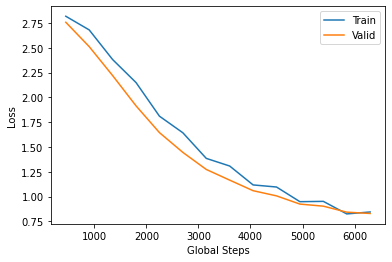

Model loaded from <== ./bertimbau_resp/6/metrics.pt


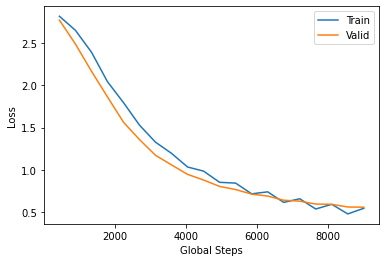

In [ ]:
id_planilha = [1,7]
for id_ in id_planilha:
  file_path = destination_folder + "/"+str(id_)
  train_loss_list, valid_loss_list, global_steps_list = load_metrics(file_path + '/metrics.pt')
  plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Global Steps')
  plt.ylabel('Loss')
  plt.title = 'Resultado do Treino id ' + str(id_)
  plt.legend()
  plt.show() 

### Avaliação
* https://towardsdatascience.com/evaluating-categorical-models-e667e17987fd
* https://towardsdatascience.com/evaluating-categorical-models-ii-sensitivity-and-specificity-e181e573cff8
* https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5
* Material de aula do Professor André
* Material do curso MicroSoft

VP = VERDADEIRO POSITIVO
VN = VERDADEIRO NEGATIVO
FP = FALSO POSITIVO
FN = FALSON NEGATIVO
TVP = TAXA DE VERDADEIRO POSITIVO
TVN = TAXA DE VERDADEIRO NEGATIVO
TFP = TAXA DE FALSO POSITIVO
TFN = TAXA DE FALSO NEGATIVO

Métricas utilizadas:

* **Acurácia:** proporção de classificações corretas feitas pelo modelo.<br>
        Acurácia = (VP + VN)/(VP+VN+VP+VN)<br>

* **Precisão:** proporção correta de classificação feita para uma determinada classe.<br>
        Precisão = (VP)/(VP + FP)

* **Revocação ou Sensibilidade:** proporção de classificações corretas de VP feitas para uma determinada classe considerando todas as instâncias do dataset de testes.<br>
      Revocação = TVP = (VP)/(VP+FN)

* **Especificidade:** proporção de classificações corretas de VN feitas para uma determinada classe considerando todas as instâncias do dataset de testes.
      Especificidade = TVN = (VN)/(VN + FP)

* **Suporte:** quantidade de instâncias de uma determinada classe no dataset de testes.

**Para o DataSet 3 - dados desbalanceados**

* **F1 é a média harmônica da precisão e da revocação.<br>

      F1 = (2 * VP) / (2 * VP + FP + FN)
* **MCC:** é o coeficiente de correlação Matthews que é utilizado para classes com tamanhos diferentes. Possui escala entre -1 e 1, sendo que 1 indica uma perfeita predição, 0 representa uma predição aleatória e -1 indica discordância total dos valores preditos e os valores verdadeiros.  

      MCC = (VP*VN - FP*FN) / (SQRT(VP+FP)*(VP+FN)*(VN+FP)*(VN+FN)
  



In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    n_classe = np.max(y_true)+1
    print(classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')



id_planilha: 5


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/5/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.8021    0.7857    0.7938        98
           1     0.9375    0.1685    0.2857        89
           2     0.6897    0.8421    0.7583        95
           3     0.8739    0.9455    0.9083       110
           4     0.7684    0.7604    0.7644        96
           5     0.8049    0.6804    0.7374        97
           6     0.7701    0.5982    0.6734       112
           7     0.8400    0.8077    0.8235       104
           8     0.7564    0.6484    0.6982        91
           9     0.6381    0.7053    0.6700        95
          10     0.9802    0.9706    0.9754       102
          11     0.8452    0.8161    0.8304        87
          12     0.9000    0.9474    0.9231       114
          13     0.6944    0.8850    0.7782       113
          14     0.8077    0.8750    0.8400        96
          15     0.5854    0.8090    0.6792        89
        

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/6/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.9080    0.8061    0.8541        98
           1     0.7344    0.5281    0.6144        89
           2     0.7549    0.8105    0.7817        95
           3     0.9211    0.9545    0.9375       110
           4     0.8523    0.7812    0.8152        96
           5     0.8721    0.7732    0.8197        97
           6     0.8269    0.7679    0.7963       112
           7     0.8125    0.8750    0.8426       104
           8     0.8764    0.8571    0.8667        91
           9     0.7742    0.7579    0.7660        95
          10     0.9901    0.9804    0.9852       102
          11     0.8523    0.8621    0.8571        87
          12     0.9478    0.9561    0.9520       114
          13     0.7445    0.9027    0.8160       113
          14     0.8300    0.8646    0.8469        96
          15     0.6604    0.7865    0.7179        89
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


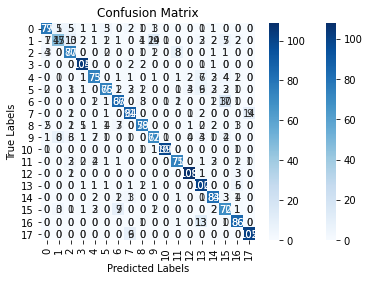

In [ ]:
#%%time    
qtd_categories=[32,32]
id_planilha = [1,7]
dataset = [1,1]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
      print('id_planilha:', id_)
      tokens = tokenizaAmostra(source_folder+str(amostra))
      best_model =BERT(qtd_categories=qtd_categories[idx]).to(device)
      load_checkpoint(destination_folder+"/"+str(id_) + '/model.pt', best_model)
      evaluate(best_model, tokens[2])

In [ ]:
#!rm ./bertimbau_all_categ/amostra_4/*.*
#!du -sh
